## LD Prune on 1KG

In [1]:
from lib import api
import dask
import warnings
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from dask.distributed import Client, LocalCluster
from matplotlib import MatplotlibDeprecationWarning
%run nb/paths.py

In [2]:
client = Client(LocalCluster(n_workers=1, threads_per_worker=1, processes=False))
client

Client Scheduler: inproc://172.17.0.2/13002/1 Dashboard: http://172.17.0.2:8787/status,Cluster Workers: 1 Cores: 1 Memory: 134.78 GB


In [3]:
path = PLINK_1KG_PATH_02
path

PosixPath('/lab/data/gwas/tutorial/2_PS_GWAS/1kG_MDS5')

#### Prep

Load 1KG dataset:

In [4]:
%%time
ds = api.read_plink(path, chunks='auto', fam_sep=' ', bim_sep='\t')
ds

CPU times: user 27.3 s, sys: 3.07 s, total: 30.4 s
Wall time: 29.3 s


<xarray.Dataset>
Dimensions:     (sample: 629, variant: 5808310)
Coordinates:
  * variant     (variant) int64 0 1 2 3 4 ... 5808306 5808307 5808308 5808309
  * sample      (sample) int64 0 1 2 3 4 5 6 7 ... 622 623 624 625 626 627 628
Data variables:
    data        (variant, sample) int8 dask.array<chunksize=(213382, 629), meta=np.ndarray>
    is_masked   (variant, sample) bool dask.array<chunksize=(213382, 629), meta=np.ndarray>
    sample_id   (sample) int64 dask.array<chunksize=(629,), meta=np.ndarray>
    fam_id      (sample) object dask.array<chunksize=(629,), meta=np.ndarray>
    pat_id      (sample) int64 dask.array<chunksize=(629,), meta=np.ndarray>
    mat_id      (sample) int64 dask.array<chunksize=(629,), meta=np.ndarray>
    is_female   (sample) int64 dask.array<chunksize=(629,), meta=np.ndarray>
    phenotype   (sample) int64 dask.array<chunksize=(629,), meta=np.ndarray>
    contig      (variant) int64 dask.array<chunksize=(1948852,), meta=np.ndarray>
    variant_id  (variant) object dask.array<chunksize=(1948852,), meta=np.ndarray>
    cm_pos      (variant) int64 dask.array<chunksize=(1948852,), meta=np.ndarray>
    pos         (variant) int64 dask.array<chunksize=(1948852,), meta=np.ndarray>
    a1          (variant) object dask.array<chunksize=(1948852,), meta=np.ndarray>
    a2          (variant) object dask.array<chunksize=(1948852,), meta=np.ndarray>
Attributes:
    type:     GenotypeCountDataset

In [9]:
%%time
intervals = api.axis_intervals(ds, window=1_000_000, unit='physical', target_chunk_size=100_000, backend='numba')

CPU times: user 25.5 s, sys: 1.11 s, total: 26.7 s
Wall time: 26 s


In [10]:
len(intervals[1])

68

In [11]:
intervals[1].to_dataset('var').to_dataframe()['count'].describe()

count    6.800000e+01
mean     1.972794e+08
std      6.302310e+07
min      4.202216e+06
25%      1.882713e+08
50%      2.089856e+08
75%      2.296391e+08
max      3.667330e+08
Name: count, dtype: float64

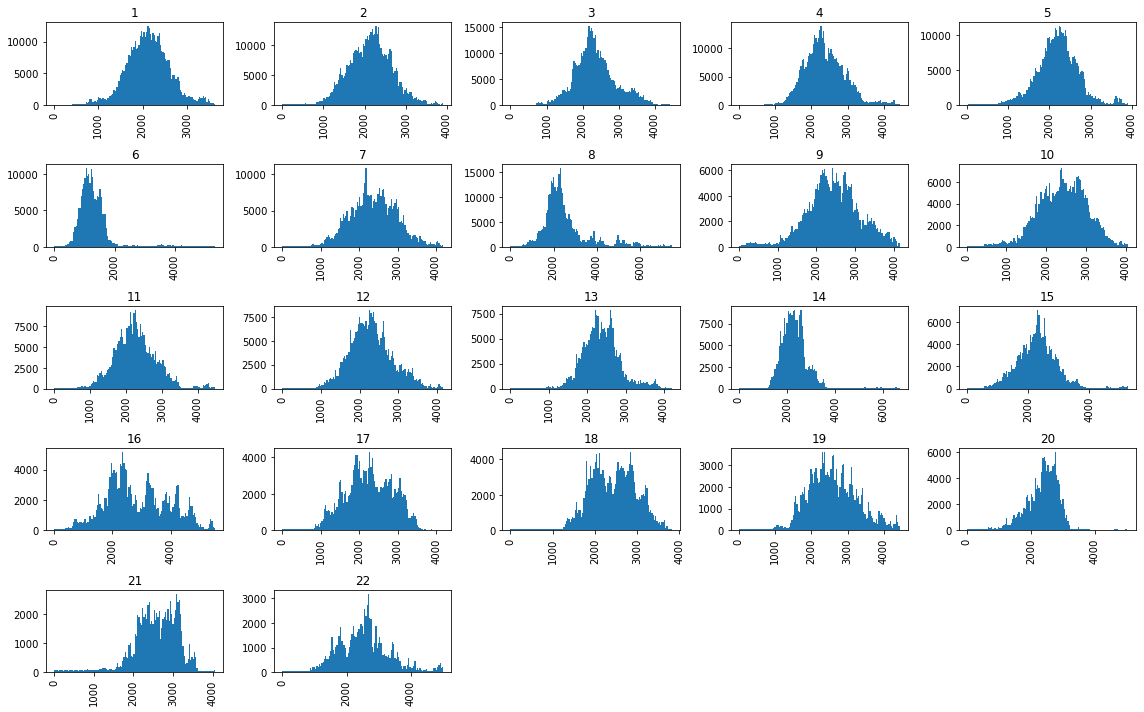

In [12]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)
    intervals[0].to_dataset('var').to_dataframe().hist('count', by='group', bins=128, figsize=(16, 10))
    plt.tight_layout()

In [13]:
%%time
ldm = api.ld_matrix(ds, intervals, threshold=0.2)

CPU times: user 660 ms, sys: 7.56 ms, total: 668 ms
Wall time: 635 ms


In [14]:
%%time
idx = api.ld_prune(ldm).compute()

CPU times: user 23min 14s, sys: 43.2 s, total: 23min 57s
Wall time: 22min 41s


In [15]:
idx.index_to_drop.shape

(5365094,)

------

PLINK

In [26]:
freq_path = '/tmp/' + path.name + '.xarray.frq'
ds[['contig', 'variant_id', 'a1', 'a2']].to_dataframe()\
    .rename(columns={'contig': 'CHR', 'variant_id': 'SNP', 'a1': 'A1', 'a2': 'A2'})\
    .assign(MAF=0.5, NCHROBS=1)\
    .to_csv(freq_path, index=False, sep=' ')
!head $freq_path

CHR SNP A1 A2 MAF NCHROBS
1 1:10583:G:A A G 0.5 1
1 1:11508:G:A A G 0.5 1
1 1:15820:G:T T G 0.5 1
1 1:16257:G:C C G 0.5 1
1 1:16378:C:T T C 0.5 1
1 1:30860:G:C C G 0.5 1
1 1:30923:T:G G T 0.5 1
1 1:40261:C:A A C 0.5 1
1 1:49298:C:T T C 0.5 1


In [31]:
%%time
%%bash -s {str(path.parent)} {str(path.name)}
set -e
cd $1
plink --bfile $2 --chr 1 --indep-pairwise 50 5 0.2 --read-freq /tmp/$2.xarray.frq --out /tmp/$2

PLINK v1.90b6.14 64-bit (7 Jan 2020)           www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /tmp/1kG_MDS5.log.
Options in effect:
  --bfile 1kG_MDS5
  --chr 1
  --indep-pairwise 50 5 0.2
  --out /tmp/1kG_MDS5
  --read-freq /tmp/1kG_MDS5.xarray.frq

128535 MB RAM detected; reserving 64267 MB for main workspace.
463525 out of 5808310 variants loaded from .bim file.
629 people (0 males, 0 females, 629 ambiguous) loaded from .fam.
Ambiguous sex IDs written to /tmp/1kG_MDS5.nosex .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 629 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
--read-freq: .frq file loaded.
463525 variants and 629 people pass filters and QC.
Note: No phen